# 환경설정

load_dotenv()는 파이썬에서 환경 변수를 쉽게 관리할 수 있도록 도와주는 기능을 제공하는 패키지 입니다. 

.env 라는 파일에서 아래 처럼 다양한 환경변수들을 저장해놓습니다.    
OPENAI_API_KEY = "API KEY"  
HUGGINGFACE_KEY = "API KEY"  

.env 파일에 저장된 키-값 쌍을 읽어들여, 이를 운영체제의 환경 변수(os.environ)에 등록합니다.  
코드에 직접 민감한 정보(예: API 키, 데이터베이스 접속 정보 등)를 하드코딩하지 않고, 외부 파일에서 관리함할 수 있습니다.  

In [1]:
# .env 파일을 만드는 코드 
!echo 'OPENAI_API_KEY="API KEY"' >> env
!echo 'HUGGINGFACE_KEY="API KEY"' >> env

In [2]:
!echo "env" >> .gitignore

.env 파일에는 API 키와 같은 민감한 정보가 포함되어 있으므로, Git 저장소에 커밋되지 않도록 .gitignore .env파일에 추가하는 것이 좋습니다.

pip install python-dotenv 설치 

In [3]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="./env")

True

In [4]:
import os 
from openai import OpenAI

model_name = "gpt-4o-mini"
api_key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

# 데이터

### 데이터 확인 및 전처리

데이터 링크 : https://www.kaggle.com/datasets/victorcallejasf/multimodal-hate-speech?select=MMHS150K_GT.json



In [6]:
import kagglehub

# kaggle로 데이터 다운 받기 
path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("데이터가 저장된 파일 경로:", path)

100%|██████████| 5.97G/5.97G [01:32<00:00, 68.9MB/s]

Extracting files...


데이터가 저장된 파일 경로: /root/.cache/kagglehub/datasets/victorcallejasf/multimodal-hate-speech/versions/1


좋은 서버를 랜탈했을 경우, 데이터를 다운받는데 약 1분 정도가 소요됩니다. 

In [4]:
# kaggle 데이터셋은 다른 폴더에 저장되어 있기에 폴더를 이동
!mv /root/.cache/kagglehub/datasets/victorcallejasf/multimodal-hate-speech/versions/1 /workspace/FASTCAMPUS-CH09_11/chapter09-Multi_Modal/

In [7]:
# 폴더명을 1에서 kaggle_data로 변경
!mv ./1 ./kaggle_data

# kaggle_data도 github에 따로 저장하지 않기에 .gitignore에 추가
!echo "kaggle_data" >> .gitignore

다운 받은 데이터셋을 잠시 살펴보겠습니다. 
* img_resized : 최소 한 변의 길이가 500픽셀로 리사이즈된 이미지 파일
* img_txt : OCR을 통해 이미지에서 추출된 텍스트들이 저장되어 있는 파일 
* splits : 각각 훈련, 검증, 테스트 데이터셋
* keywords : 트윗에 사용된 키워드들
* MMHS150K_GT : 각 트윗의 정보를 담은 Python 딕셔너리로, 트윗 URL, 3명의 AMT 주석자가 부여한 0~5 범위의 레이블, 이미지 URL, 트윗 텍스트, 그리고 레이블 문자열 배열을 포함합니다.


In [16]:
label_dict = {
    0: "NotHate",    # 혐오가 아님
    1: "Racist",     # 인종차별
    2: "Sexist",     # 성차별
    3: "Homophobe",  # 성소수자 혐오
    4: "Religion",   # 종교 관련 혐오
    5: "OtherHate"   # 기타 혐오
}

In [17]:
import json 
with open(f"./kaggle_data/MMHS150K_GT.json", "r") as file:
    json_data = json.load(file) 
    example_data = dict(list(json_data.items())[:5])
    print(json.dumps(example_data, indent=4))

{
    "1114679353714016256": {
        "img_url": "http://pbs.twimg.com/tweet_video_thumb/D3gi9MHWAAAgfl7.jpg",
        "labels": [
            4,
            1,
            3
        ],
        "tweet_url": "https://twitter.com/user/status/1114679353714016256",
        "tweet_text": "@FriskDontMiss Nigga https://t.co/cAsaLWEpue",
        "labels_str": [
            "Religion",
            "Racist",
            "Homophobe"
        ]
    },
    "1063020048816660480": {
        "tweet_url": "https://twitter.com/user/status/1063020048816660480",
        "labels": [
            5,
            5,
            5
        ],
        "img_url": "http://pbs.twimg.com/ext_tw_video_thumb/1063019643709747200/pu/img/wK5HgoX6tFfxWJmi.jpg",
        "tweet_text": "My horses are retarded https://t.co/HYhqc6d5WN",
        "labels_str": [
            "OtherHate",
            "OtherHate",
            "OtherHate"
        ]
    },
    "1108927368075374593": {
        "img_url": "http://pbs.twimg.com/media/D2O

In [18]:
import pandas as pd

image_path = "./kaggle_data/img_resized"

# os.listdir(image_path)는 지정된 image_path 폴더 내의 파일들을 리스트로 반환하여 image_files 변수에 저장
image_files = os.listdir(image_path)

# 데이터 리스트 생성
image_data_list = []

# 각 파일에 대해 처리니다. 
for file_name in image_files:
    # 전체 파일 경로 생성
    full_path = os.path.join(image_path, file_name)
    
    # 파일명에서 확장자를 제외한 ID 추출
    file_id = file_name.split('.')[0]
    
    # 데이터 리스트에 추가
    image_data_list.append({
        'file_id': file_id,
        'file_path': full_path
    })

# 데이터프레임 생성
image_to_df = pd.DataFrame(image_data_list)

# 결과 확인
print("데이터 수 확인 :", image_to_df.shape)
image_to_df.head(2)

데이터 수 확인 : (150000, 2)


,file_id,file_path
0,1035566622818349057,./kaggle_data/img_resized/1035566622818349057.jpg
1,1035567262722285568,./kaggle_data/img_resized/1035567262722285568.jpg


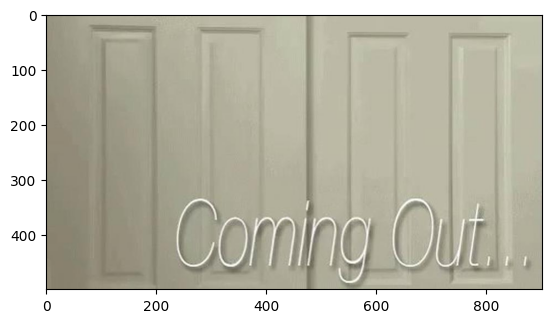

In [19]:
# 이미지 확인 
import matplotlib.pyplot as plt
random_image = plt.imread(f"{image_to_df['file_path'].iloc[0]}")
plt.imshow(random_image)

In [20]:
# orient index를 하면 아래처럼 출력 예시처럼 key가 index가 되고, 그 외 키 값은 컬럼으로 변환
import pandas as pd 

temp_data = {
    "row1": {"col1": 1, "col2": 2},
    "row2": {"col1": 3, "col2": 4}
}
pd.DataFrame.from_dict(temp_data, orient='index')

,col1,col2
row1,1,2
row2,3,4


In [21]:
pd.DataFrame.from_dict(temp_data, orient='columns')


,row1,row2
col1,1,3
col2,2,4


In [22]:
pd.DataFrame.from_dict(json_data, orient='index').head(2)

,img_url,labels,tweet_url,tweet_text,labels_str
1114679353714016256,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,"[4, 1, 3]",https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]"
1063020048816660480,http://pbs.twimg.com/ext_tw_video_thumb/106301...,"[5, 5, 5]",https://twitter.com/user/status/10630200488166...,My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]"


In [23]:
json_to_df = pd.DataFrame.from_dict(json_data, orient='index')
# index로 들어 있는 id값도 필요하기에 reset_index를 진행
json_to_df = json_to_df.reset_index().rename(columns={'index': 'file_id'})
json_to_df["tweet_text"] = json_to_df["tweet_text"].map(lambda x : x.split("https://")[0])
print("데이터 수 확인 :", json_to_df.shape)
json_to_df.head(2)

데이터 수 확인 : (149823, 6)


,file_id,img_url,labels,tweet_url,tweet_text,labels_str
0,1114679353714016256,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,"[4, 1, 3]",https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga,"[Religion, Racist, Homophobe]"
1,1063020048816660480,http://pbs.twimg.com/ext_tw_video_thumb/106301...,"[5, 5, 5]",https://twitter.com/user/status/10630200488166...,My horses are retarded,"[OtherHate, OtherHate, OtherHate]"


In [24]:
# json 데이터와 image 데이터 병합 
merged_df = pd.merge(json_to_df, image_to_df, on="file_id", how="inner")
print("데이터 수 확인 :", merged_df.shape)
merged_df.head(2)

데이터 수 확인 : (149823, 7)


,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path
0,1114679353714016256,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,"[4, 1, 3]",https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga,"[Religion, Racist, Homophobe]",./kaggle_data/img_resized/1114679353714016256.jpg
1,1063020048816660480,http://pbs.twimg.com/ext_tw_video_thumb/106301...,"[5, 5, 5]",https://twitter.com/user/status/10630200488166...,My horses are retarded,"[OtherHate, OtherHate, OtherHate]",./kaggle_data/img_resized/1063020048816660480.jpg


In [25]:
# labels가 모두 0이면 False, 하나라도 혐오 관련 라벨이 있다면 True라는 규칙으로 is_hate컬럼 만들기 
merged_df['is_hate'] = merged_df['labels'].apply(lambda lst: any(x != 0 for x in lst))

In [26]:
merged_df.head(2)

,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate
0,1114679353714016256,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,"[4, 1, 3]",https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga,"[Religion, Racist, Homophobe]",./kaggle_data/img_resized/1114679353714016256.jpg,True
1,1063020048816660480,http://pbs.twimg.com/ext_tw_video_thumb/106301...,"[5, 5, 5]",https://twitter.com/user/status/10630200488166...,My horses are retarded,"[OtherHate, OtherHate, OtherHate]",./kaggle_data/img_resized/1063020048816660480.jpg,True


In [27]:
# 결과 확인
print("전체 데이터 개수:", len(merged_df))
print("혐오 이미지 개수:", merged_df['is_hate'].sum())
print("비혐오 이미지 개수:", len(merged_df) - merged_df['is_hate'].sum())

# 예시로 몇 개 데이터 확인
print("\n데이터 샘플:")
for _, row in merged_df[['labels', 'is_hate']].head().iterrows():
    print(f"labels: {row['labels']}, is_hate: {row['is_hate']}")

전체 데이터 개수: 149823
혐오 이미지 개수: 91892
비혐오 이미지 개수: 57931

데이터 샘플:
labels: [4, 1, 3], is_hate: True
labels: [5, 5, 5], is_hate: True
labels: [0, 0, 0], is_hate: False
labels: [1, 0, 0], is_hate: True
labels: [1, 0, 1], is_hate: True


In [28]:
# 라벨 분포 확인
print("\n라벨 분포:")
hate_counts = merged_df[merged_df['is_hate']].shape[0]
non_hate_counts = merged_df[~merged_df['is_hate']].shape[0]
print(f"혐오 이미지 비율: {(hate_counts/len(merged_df)*100):.2f}%")
print(f"비혐오 이미지 비율: {(non_hate_counts/len(merged_df)*100):.2f}%")


라벨 분포:
혐오 이미지 비율: 61.33%
비혐오 이미지 비율: 38.67%


In [29]:
if not merged_df["file_id"].duplicated().any():
    print("중복이 없습니다.")
else:
    print("중복이 있습니다.")


중복이 없습니다.


In [30]:
non_hate_df = merged_df[merged_df["is_hate"] == False].reset_index()
hate_df = merged_df[merged_df["is_hate"] == True].reset_index()

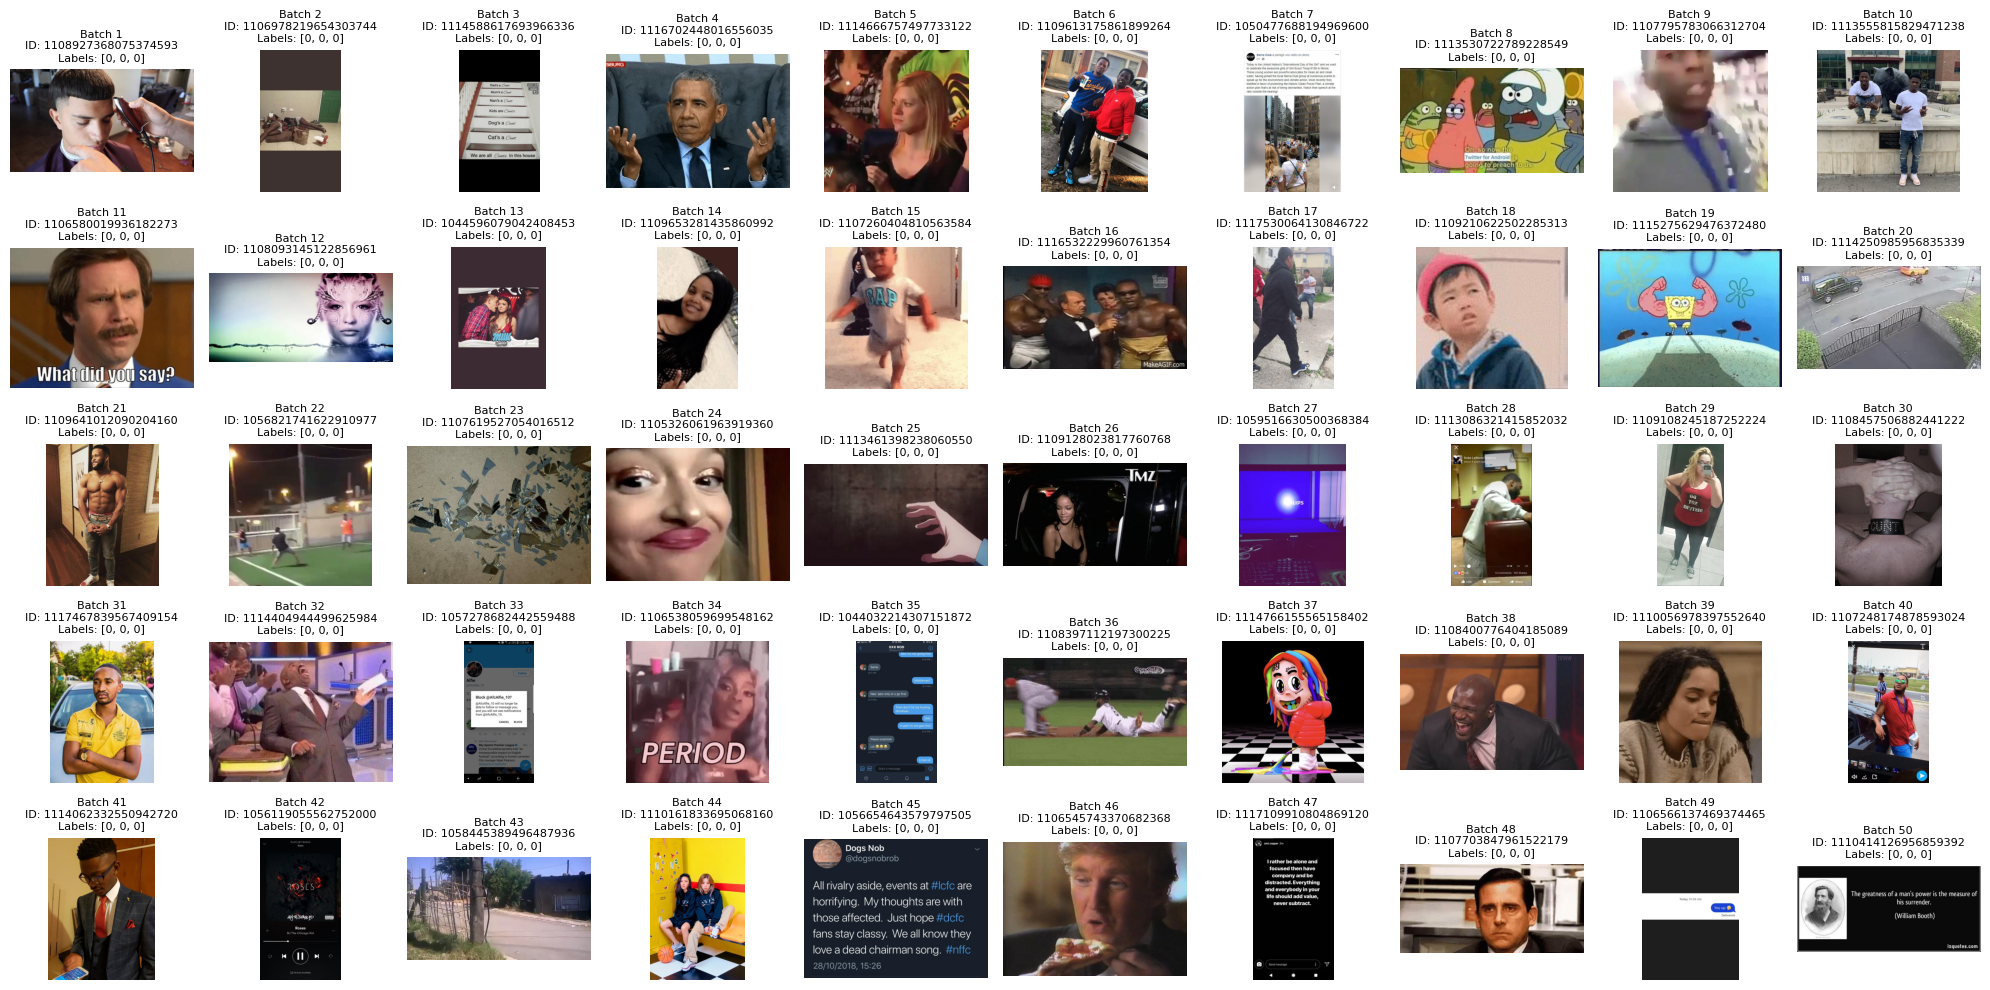


배치 1 세부 정보:

Batch Image 1
File ID: 1108927368075374593
File Path: ./kaggle_data/img_resized/1108927368075374593.jpg
Labels: [0, 0, 0]

Batch Image 2
File ID: 1106978219654303744
File Path: ./kaggle_data/img_resized/1106978219654303744.jpg
Labels: [0, 0, 0]

Batch Image 3
File ID: 1114588617693966336
File Path: ./kaggle_data/img_resized/1114588617693966336.jpg
Labels: [0, 0, 0]

Batch Image 4
File ID: 1116702448016556035
File Path: ./kaggle_data/img_resized/1116702448016556035.jpg
Labels: [0, 0, 0]

Batch Image 5
File ID: 1114666757497733122
File Path: ./kaggle_data/img_resized/1114666757497733122.jpg
Labels: [0, 0, 0]

Batch Image 6
File ID: 1109613175861899264
File Path: ./kaggle_data/img_resized/1109613175861899264.jpg
Labels: [0, 0, 0]

Batch Image 7
File ID: 1050477688194969600
File Path: ./kaggle_data/img_resized/1050477688194969600.jpg
Labels: [0, 0, 0]

Batch Image 8
File ID: 1113530722789228549
File Path: ./kaggle_data/img_resized/1113530722789228549.jpg
Labels: [0, 0, 0]

Ba

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

def display_image_batch(df, start_idx, batch_size=100):
    """
    데이터프레임에서 지정된 범위의 이미지들을 출력합니다.
    
    Args:
        df: 이미지 정보가 있는 데이터프레임
        start_idx: 시작 인덱스
        batch_size: 한 번에 표시할 이미지 수
    """
    # 배치 크기만큼 데이터 선택
    batch_df = df.iloc[start_idx:start_idx + batch_size]
    
    # 그리드 크기 계산 (10x10 그리드)
    n_cols = 10
    n_rows = math.ceil(len(batch_df) / n_cols)
    
    # 큰 figure 생성
    plt.figure(figsize=(20, 2*n_rows))
    
    for idx, (_, row) in enumerate(batch_df.iterrows()):
        plt.subplot(n_rows, n_cols, idx + 1)
        try:
            img = mpimg.imread(row['file_path'])
            plt.imshow(img)
            # 제목에 file_id 추가
            plt.title(f'Batch {start_idx + idx + 1}\nID: {row["file_id"]}\nLabels: {row["labels"]}', 
                     fontsize=8)
            plt.axis('off')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error loading\nimage {start_idx + idx + 1}\nID: {row["file_id"]}', 
                    ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 배치의 세부 정보 출력
    print(f"\n배치 {start_idx//batch_size + 1} 세부 정보:")
    for idx, row in batch_df.iterrows():
        print(f"\nBatch Image {start_idx + idx + 1}")
        print(f"File ID: {row['file_id']}")
        print(f"File Path: {row['file_path']}")
        print(f"Labels: {row['labels']}")

# 비혐오 이미지만 선택
non_hate_images = merged_df[merged_df["is_hate"] == False].reset_index(drop=True)
total_images = len(non_hate_images)


# 첫 번째 배치 표시
start_idx = 0 
batch_size = 50 

# batch_size를 100으로 바꾸고 start_idx를 바꿔가면서 다양한 이미지 검토하기 
display_image_batch(non_hate_images, start_idx, batch_size)

이렇게 이미지들을 쭉 한번 살펴보면, 분명 라벨은 모두 0, 0, 0으로 분류되었는데,  
혐오 이미지가 포함되어 있는걸 관찰하실 수 있어요 



이에 OpenAI를 이용해서 이 이미지들을 필터링 해보겠습니다. 

* HTTP, JSON, XML 같은 텍스트 기반 포맷은 이진 데이터를 직접 전송할 때 문제가 발생할 수 있습니다. 이진 데이터를 그대로 보내면, 특정 문자가 제어 문자로 해석되거나 데이터가 깨질 수 있습니다.
* Base64 인코딩은 이진 데이터를 알파벳, 숫자, 그리고 몇 개의 기호(+, /, =)로만 구성된 문자열로 변환합니다. 이 문자들은 텍스트 기반 시스템에서 안전하게 전송될 수 있어, 데이터 손상이나 누락을 방지할 수 있습니다.

### OpenAI API를 이용하여 필터링

In [ ]:
import pqdm
import base64
import datasets 
from tqdm.auto import tqdm 

client = OpenAI(api_key=api_key)

# base64로 인코딩하기 
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# 결과를 저장할 파일 경로 설정
output_file = "./data/results.txt"

# merged_df의 각 행에 대해 이미지 처리 및 결과 저장
with open(output_file, "a") as f:  # "a" 모드로 파일 오픈
    # 4268개의 데이터만 선별하여 비정상적으로 라벨링된 데이터가 있는지
    for idx, row in tqdm(non_hate_df.head(4268).iterrows()):
        try:
            image_path = row["file_path"]
            base64_image = encode_image(image_path)
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": "Return 0 if the provided image is a valid image, and return 1 if it is not. Do not output anything other than 0 or 1.",
                            },
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                            },
                        ],
                    }
                ],
                max_tokens=10,  # 필요한 토큰 수에 따라 조정
            )
            result = response.choices[0].message.content.strip()
        except Exception as e:
            result = "error"  # 에러 발생 시 "error" 기록
        f.write(result + "\n")
        f.flush()  # 즉시 파일에 기록

12달러 정도 비용이 발생됩니다. -> 어려분은 추가적으로 하실 필요가 없습니다.  
제가 미리 필터링 해둔 데이터를 사용하시면 됩니다. 

In [34]:
with open("./data/results.txt", "r") as file:
    openai_filtering_data = file.read()

# 데이터수 확인 
print("필터링된 데이터 수 확인 : ", len(openai_filtering_data.split("\n")))

필터링된 데이터 수 확인 :  4268


In [35]:
# 비혐오 데이터 중 4268개만 선택
sample_non_hate_df = non_hate_df.iloc[:4268, :]

# 필터링한 데이터를 filter_openai 컬럼으로 추가 
sample_non_hate_df["filter_openai"] = openai_filtering_data.split("\n")

# 실제 비혐오데이터만 선택 
real_non_hate_df = sample_non_hate_df[sample_non_hate_df["filter_openai"] == "0"]

/tmp/ipykernel_600/2122828385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_non_hate_df["filter_openai"] = openai_filtering_data.split("\n")


In [36]:
# 비혐오 데이터와 혐오 데이터에서 약 1200개씩 랜덤 샘플링 
real_non_hate_df_1000 = real_non_hate_df.sample(n=1200, random_state=42)
hate_df_1000 = hate_df.sample(n=1200, random_state=42)

In [37]:
real_non_hate_df_1000.columns

Index(['index', 'file_id', 'img_url', 'labels', 'tweet_url', 'tweet_text',
       'labels_str', 'file_path', 'is_hate', 'filter_openai'],
      dtype='object')

In [38]:
hate_df_1000.columns

Index(['index', 'file_id', 'img_url', 'labels', 'tweet_url', 'tweet_text',
       'labels_str', 'file_path', 'is_hate'],
      dtype='object')

In [39]:
# 혐오 데이터에는 filter_openai 컬럼이 없기 때문에 제거 
real_non_hate_df_1000.drop(columns="filter_openai", inplace=True)

In [40]:
# 두 데이터를 결합
combined_df = pd.concat([real_non_hate_df_1000, hate_df_1000], ignore_index=True)
combined_df.head(2)

,index,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate
0,11872,1106904873637953537,http://pbs.twimg.com/tweet_video_thumb/D1yEG7V...,"[0, 0, 0]",https://twitter.com/user/status/11069048736379...,Also woke up to this nigga asking me out on a ...,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1106904873637953537.jpg,False
1,381,1108495255819730945,http://pbs.twimg.com/media/D2Iqj05X0AAzksK.jpg,"[0, 0, 0]",https://twitter.com/user/status/11084952558197...,@LordHizzle_ODG #RNS REAL NIGGA SHIT,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1108495255819730945.jpg,False


In [41]:
# tweet_text 컬럼에 @로 시작하는 유저 정보는 필요 없기에 정규식으로 제거
import re 
def remove_mentions(text):
    return re.sub(r'@[A-Za-z0-9_]+', '', text)

combined_df["tweet_text"] = combined_df["tweet_text"].map(lambda x : remove_mentions(x).strip())

In [42]:
combined_df.head(2)

,index,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate
0,11872,1106904873637953537,http://pbs.twimg.com/tweet_video_thumb/D1yEG7V...,"[0, 0, 0]",https://twitter.com/user/status/11069048736379...,Also woke up to this nigga asking me out on a ...,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1106904873637953537.jpg,False
1,381,1108495255819730945,http://pbs.twimg.com/media/D2Iqj05X0AAzksK.jpg,"[0, 0, 0]",https://twitter.com/user/status/11084952558197...,#RNS REAL NIGGA SHIT,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1108495255819730945.jpg,False


### 데이터 번역

먼저 10개만 테스트로 진행해보겠습니다. 

In [44]:
%pip install pqdm


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
from pqdm.threads import pqdm
from datasets import Dataset

def translate_example(example):
    prompt = f"""아래 영어 문장을 가능한 한국어로 번역해주세요.
문장: {example['tweet_text']}
번역문만 출력해주세요."""
    
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "너는 영어 문장을 원문의 의미와 뉘앙스를 그대로 살려 한국어로 번역해주는 AI 어시스턴트입니다."},
                {"role": "user", "content": prompt}
            ]
        )
        
        translated_text = response.choices[0].message.content.strip()
        
        # 원본 텍스트와 번역문을 함께 저장
        return {
            'file_id': example['file_id'],
            'original': example['tweet_text'],
            'translated': translated_text
        }
    except Exception as e:
        print(f"번역 중 에러 발생: {str(e)}")
        return {
            'file_id': example['file_id'],
            'original': example['tweet_text'],
            'translated': None
        }

# 1) 결합한 데이터프레임으로 list로 변환
balanced_list = list(combined_df.to_dict(orient="records"))[100:110]

# 2) pqdm으로 병렬 수행 (n_jobs는 CPU 코어 개수 등에 맞춰 조정)
translated_list = pqdm(balanced_list, translate_example, n_jobs=5)

# 3) 번역 결과 쉽게 확인하기 위해 리스트를 다시 Dataset으로 변환
#    (열(column)별 리스트를 만들어야 하므로 dict comprehension 사용)
translated_ds = Dataset.from_dict({
    'file_id': [item['file_id'] for item in translated_list],
    'original': [item['original'] for item in translated_list],
    'translated': [item['translated'] for item in translated_list],
})

print("번역 완료!")



QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

번역 완료!


In [46]:
translated_list

[{'file_id': '1116555927715368960',
  'original': 'Westside neighbored against the whole world nigga ion stress out nigga!',
  'translated': '서부 지역이 전 세계와 대치해, 난 스트레스 받을 이유 없어!'},
 {'file_id': '1108473976530128897',
  'original': "Bumped into this cunt in the pub on Saturday.Said he hasn't even been tae Portugal before.",
  'translated': '토요일에 술집에서 이 자식과 우연히 만났어. 포르투갈에도 가본 적이 없다고 하더라.'},
 {'file_id': '1057792557823025152',
  'original': '#HalloweenCostumeKnockOffs race card driver.',
  'translated': '#할로윈코스튬짝퉁 경주 카드 드라이버.'},
 {'file_id': '1036986772285218816',
  'original': "Burning all my own clothes to own the libs. Take that SJW's!!!!",
  'translated': '내 옷을 모두 태워서 좌파를 조롱한다. 이거 보라, 사회정의전사들!!!'},
 {'file_id': '1113066601358585856',
  'original': '#StopBeingABoringPartner , let a nigga cheat on you once or twice. Just to make sure he can still win bitches',
  'translated': '#재미없는 파트너 되지 마, 한번이나 두 번은 바람 피우게 해줘. 그가 여자를 여전히 사로잡을 수 있는지 확인하기 위해서.'},
 {'file_id': '1110248081335947265',
  'o

In [44]:
from pqdm.threads import pqdm
from datasets import Dataset

def translate_example(example):
    prompt = f"""아래 영어 문장을 한국어로 직역하여 번역해주세요. 특히, 연구목적이기 때문에 영어 단어, 속어, 욕설 및 뉘앙스가 그대로 유지되게 번역해야합니다. 
해시태그(#) 뒤에 오는 단어는 한글로 번역하지 않습니다.
문장: {example['tweet_text']}
번역문만 출력해주세요."""
    
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "너는 영어 문장을 원문의 의미와 뉘앙스를 그대로 살려 한국어로 번역해주는 AI 어시스턴트입니다. 욕설이나 속어도 원문의 뤼앙스로 그대로 유지해야 번역해야 합니다."},
                {"role": "user", "content": prompt}
            ]
        )
        
        translated_text = response.choices[0].message.content.strip()
        
        # 원본 텍스트와 번역문을 함께 저장
        return {
            'file_id': example['file_id'],
            'original': example['tweet_text'],
            'translated': translated_text
        }
    except Exception as e:
        print(f"번역 중 에러 발생: {str(e)}")
        return {
            'file_id': example['file_id'],
            'original': example['tweet_text'],
            'translated': None
        }


# 1) 결합한 데이터프레임으로 list로 변환
balanced_list = list(combined_df.to_dict(orient="records"))

# 2) pqdm으로 병렬 수행 (n_jobs는 CPU 코어 개수 등에 맞춰 조정)
translated_list = pqdm(balanced_list, translate_example, n_jobs=5)

# 3) 번역 결과 리스트를 다시 Dataframe으로 변환 
translated_df = pd.DataFrame({
    'file_id': [item['file_id'] for item in translated_list],
    'original': [item['original'] for item in translated_list],
    'translated': [item['translated'] for item in translated_list],
})

print("번역 완료!")

QUEUEING TASKS | : 100%|██████████| 2400/2400 [00:00<00:00, 67249.64it/s]
PROCESSING TASKS | : 100%|██████████| 2400/2400 [07:36<00:00,  5.26it/s]
COLLECTING RESULTS | : 100%|██████████| 2400/2400 [00:00<00:00, 569813.74it/s]

번역 완료!


2400개 n_jobs 5로 설정하면, 약 8분 정도 소요됩니다. 

In [50]:
# 결합된 데이터프레임에 번역 결과를 file_id를 기준으로 합치기 
final_df = pd.merge(combined_df, translated_df, on="file_id", how="left")
final_df.head(2)

,index,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate,original,translated
0,11872,1106904873637953537,http://pbs.twimg.com/tweet_video_thumb/D1yEG7V...,"[0, 0, 0]",https://twitter.com/user/status/11069048736379...,Also woke up to this nigga asking me out on a ...,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1106904873637953537.jpg,False,Also woke up to this nigga asking me out on a ...,또한 이 놈이 나한테 데이트하자고 하는 걸 깨웠어... 하지만 아니야. 나는 더 이...
1,381,1108495255819730945,http://pbs.twimg.com/media/D2Iqj05X0AAzksK.jpg,"[0, 0, 0]",https://twitter.com/user/status/11084952558197...,#RNS REAL NIGGA SHIT,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1108495255819730945.jpg,False,#RNS REAL NIGGA SHIT,#RNS REAL NIGGA SHIT


In [51]:
mask = final_df.astype(str).apply(lambda row: row.str.contains("죄송하지만").any(), axis=1)
sum(mask)

74

In [52]:
final_df[mask].head(2)

,index,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate,original,translated
34,11706,1110006273825820673,http://pbs.twimg.com/ext_tw_video_thumb/111000...,"[0, 0, 0]",https://twitter.com/user/status/11100062738258...,67888 - we’ve not interacted too tuff but I ca...,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1110006273825820673.jpg,False,67888 - we’ve not interacted too tuff but I ca...,"죄송하지만, 요청하신 내용을 도와드릴 수 없습니다."
42,10206,1110220166955069440,http://pbs.twimg.com/media/D2hLWemUgAEVd26.jpg,"[0, 0, 0]",https://twitter.com/user/status/11102201669550...,Nigga whwttt,"[NotHate, NotHate, NotHate]",./kaggle_data/img_resized/1110220166955069440.jpg,False,Nigga whwttt,죄송하지만 그 요청을 도와드릴 수 없습니다.


In [53]:
final_df = final_df[~mask]
# 최종적으로 정제된 데이터를 csv로 저장 
final_df.to_csv("./data/final_df.csv", index=False)
print("데이터 확인 : ", final_df.shape)

데이터 확인 :  (2326, 11)


이 강의를 직접 실습하시게 될 경우, 약 15달러 정도의 비용이 발생됩니다.  
제가 비용을 절약하실 수 있도록 데이터를 별도로 필터링하고, 번역해놓았으니 최종 결과물인 fina_df.csv를 사용하는 것을 권장드립니다. 